In [2]:
import os
os.chdir(os.environ.get('PROJECT_PATH'))
import pandas as pd
import matplotlib.pyplot as plt
from traindelays.ml_logic import preprocess as p
from traindelays import utils as u
from traindelays.params import *
%load_ext autoreload
%autoreload 2

**Table of contents**<a id='toc0_'></a>    
- [Features Construction](#toc1_)    
  - [Loading the Data](#toc1_1_)    
  - [Temporal Features](#toc1_2_)    
    - [ENGLISH DAY TYPE](#toc1_2_1_)    
    - [PLANNED_ORIG_GBTT_DATETIME_AFF and PLANNED_DEST_GBTT_DATETIME_AFF](#toc1_2_2_)    
  - [Geographical Features](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Features Construction](#toc0_)

## <a id='toc1_1_'></a>[Loading the Data](#toc0_)

In [3]:
df = u.read_data_from_bq(credentials=SERVICE_ACCOUNT,gcp_project=GCP_PROJECT,bq_dataset=BQ_DATASET,table=RAIL_DATA_TABLE_ID)
df.head()


,FINANCIAL_YEAR_AND_PERIOD,ORIGIN_DEPARTURE_DATE,TRUST_TRAIN_ID_AFFECTED,PLANNED_ORIG_LOC_CODE_AFF,PLANNED_ORIG_WTT_DATETIME_AFF,PLANNED_ORIG_GBTT_DATETIME_AFF,PLANNED_DEST_LOC_CODE_AFFECTED,PLANNED_DEST_WTT_DATETIME_AFF,PLANNED_DEST_GBTT_DATETIME_AFF,TRAIN_SERVICE_CODE_AFFECTED,...,INCIDENT_EQUIPMENT,INCIDENT_DESCRIPTION,REACTIONARY_REASON_CODE,INCIDENT_RESPONSIBLE_TRAIN,RESP_TRAIN,REACT_TRAIN,START_STANOX,END_STANOX,EVENT_DATETIME,PFPI_MINUTES
0,2021/22_P04,03-Jul-21,722C28MK03,72000,2021-03-07 12:15:00,2021-03-07 12:15:00,72410,2021-03-07 13:05:00,2021-03-07 13:05:00,22216000,...,221108,9M50 3 LATE START EDB,YD,None,None,361A27MH03,72311,72410,2021-03-07 13:09:00,4.0
1,2019/20_P12,05-Feb-20,522Y30MZ05,52226,2020-05-02 20:05:00,2020-05-02 20:05:00,87219,2020-05-02 21:07:00,2020-05-02 21:07:00,22214000,...,334014,2C28 UNIT FLT WES,YD,2C28,062C28MI05,522N36MY05,72419,72275,2020-05-02 20:48:00,3.0
2,2019/20_P12,05-Feb-20,872N45M705,87132,2020-05-02 21:07:00,2020-05-02 21:07:00,52226,2020-05-02 22:07:00,2020-05-02 22:09:00,22214000,...,334014,2C28 UNIT FLT WES,YA,2C28,062C28MI05,522N38MZ05,87132,87132,2020-05-02 21:14:00,4.0
3,2019/20_P12,05-Feb-20,522Y28MY05,52226,2020-05-02 19:53:00,2020-05-02 19:53:00,87219,2020-05-02 20:54:00,2020-05-02 20:55:00,22214000,...,334014,2C28 UNIT FLT WES,YI,2C28,062C28MI05,872N23MX05,52226,52226,2020-05-02 19:55:00,2.0
4,2019/20_P12,05-Feb-20,522Y48M805,52226,2020-05-02 22:14:00,2020-05-02 22:14:00,87219,2020-05-02 23:21:00,2020-05-02 23:21:00,22214000,...,334014,2C28 UNIT FLT WES,YI,2C28,062C28MI05,872N45M705,52226,52226,2020-05-02 22:23:00,9.0


Data is splitted according to their index, in order to have a stable train/test split.

In [4]:
train, test = u.split_train_test_by_id(data = df, test_ratio = 0.33, id_column = 'index')
X_train =train.drop(columns=['PFPI_MINUTES'])
X_test = test.drop(columns=['PFPI_MINUTES'])
y_train = train['PFPI_MINUTES']
y_test = test['PFPI_MINUTES']

The features dataset is then cleaned of redundant columns.

In [5]:
X_train = p.drop_columns(X_train)
print(X_train.dtypes)

Dropped columns: START_STANOX, END_STANOX, PLANNED_ORIG_WTT_DATETIME_AFF, PLANNED_DEST_WTT_DATETIME_AFF, FINANCIAL_YEAR_AND_PERIOD, ORIGIN_DEPARTURE_DATE, INCIDENT_CREATE_DATE, INCIDENT_START_DATETIME, INCIDENT_END_DATETIME, TRAILING_LOAD_AFFECTED, TIMING_LOAD_AFFECTED, REACT_TRAIN, INCIDENT_RESPONSIBLE_TRAIN, RESP_TRAIN, INCIDENT_EQUIPMENT, INCIDENT_NUMBER, TRUST_TRAIN_ID_AFFECTED, INCIDENT_RESPONSIBLE_TRAIN, RESP_TRAIN, INCIDENT_EQUIPMENT, INCIDENT_NUMBER, INCIDENT_DESCRIPTION, EVENT_DATETIME
PLANNED_ORIG_LOC_CODE_AFF                 object
PLANNED_ORIG_GBTT_DATETIME_AFF    datetime64[us]
PLANNED_DEST_LOC_CODE_AFFECTED            object
PLANNED_DEST_GBTT_DATETIME_AFF    datetime64[us]
TRAIN_SERVICE_CODE_AFFECTED               object
SERVICE_GROUP_CODE_AFFECTED               object
ENGLISH_DAY_TYPE                          object
APP_TIMETABLE_FLAG_AFF                    object
TRAIN_SCHEDULE_TYPE_AFFECTED              object
TRACTION_TYPE_AFFECTED                    object
UNIT_CLASS

## <a id='toc1_2_'></a>[Temporal Features](#toc0_)

We have the following temporal information:

:pushpin: **ENGLISH_DAY_TYPE** : It indicates if it's a weekday (WD), Saturday (SU), Sunday (SA) or bank holiday (BH). 

:pushpin: **PLANNED_ORIG_GBTT_DATETIME_AFF** and **PLANNED_DEST_GBTT_DATETIME_AFF**: The planned arrival and departure times according to the published timetable. 

:triangular_flag_on_post: Dates need to be offset for Daylight Saving Time.


### <a id='toc1_2_1_'></a>[ENGLISH DAY TYPE](#toc0_)

**ENGLISH_DAY_TYPE** does not have any missing values. However, in 2020, an additionaly category (BD) was logged (to keep track of Boxing Day). Since it is has been used only for this year, its instance will be substituted with "BH".

In [6]:
display(X_train['ENGLISH_DAY_TYPE'].isna().sum())

0

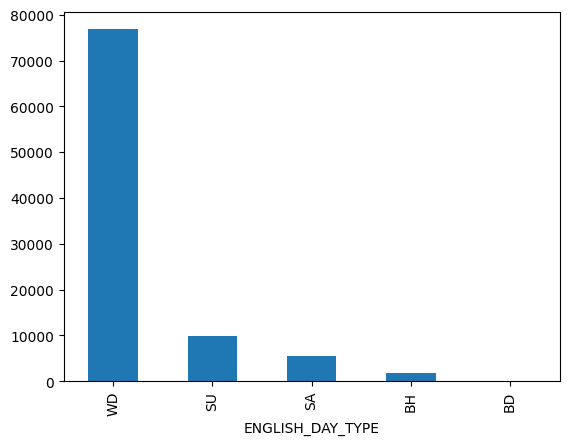

In [7]:
X_train['ENGLISH_DAY_TYPE'].value_counts().plot(kind='bar')
plt.show()

In [8]:
print("Before subsituting for Boxing Day category")
display(X_train['ENGLISH_DAY_TYPE'].value_counts(dropna=False))
X_train = p.boxing_day_holiday_normalization(X_train)
print("After subsituting for Boxing Day category")
display(X_train['ENGLISH_DAY_TYPE'].value_counts(dropna=False))

Before subsituting for Boxing Day category


ENGLISH_DAY_TYPE
WD    76832
SU     9801
SA     5501
BH     1793
BD        3
Name: count, dtype: int64

After subsituting for Boxing Day category


ENGLISH_DAY_TYPE
WD    76832
SU     9801
SA     5501
BH     1796
Name: count, dtype: int64

### <a id='toc1_2_2_'></a>[PLANNED_ORIG_GBTT_DATETIME_AFF and PLANNED_DEST_GBTT_DATETIME_AFF](#toc0_)

**PLANNED_ORIG_GBTT_DATETIME_AFF** and **PLANNED_DEST_GBTT_DATETIME_AFF** do, but since trains not comparing into the GBTT timetables are freight trains. Therefore, we can drop these rows. 

In [9]:
dates_cols = ['PLANNED_ORIG_GBTT_DATETIME_AFF','PLANNED_DEST_GBTT_DATETIME_AFF']
X_train[dates_cols].isna().sum()/len(X_train)
X_train.dropna(subset = ['PLANNED_ORIG_GBTT_DATETIME_AFF','PLANNED_DEST_GBTT_DATETIME_AFF'], inplace = True)

To make all the dates comparables, we have to offset the daylight saving time.

In [10]:
X_train[dates_cols] = X_train[dates_cols].apply(p.apply_dst_offset,axis=1)

Features that can be obtained by **PLANNED_ORIG_GBTT_DATETIME_AFF** and **PLANNED_DEST_GBTT_DATETIME_AFF** are Day, Week and Month of the departure date.

In [11]:
X_train['PLANNED_ORIG_GBTT_MONTH'] = X_train['PLANNED_ORIG_GBTT_DATETIME_AFF'].dt.month
X_train['PLANNED_ORIG_GBTT_WEEK'] = X_train['PLANNED_ORIG_GBTT_DATETIME_AFF'].dt.strftime("%V").astype('int32')
X_train['PLANNED_ORIG_GBTT_DAY']  = X_train['PLANNED_ORIG_GBTT_DATETIME_AFF'].dt.day


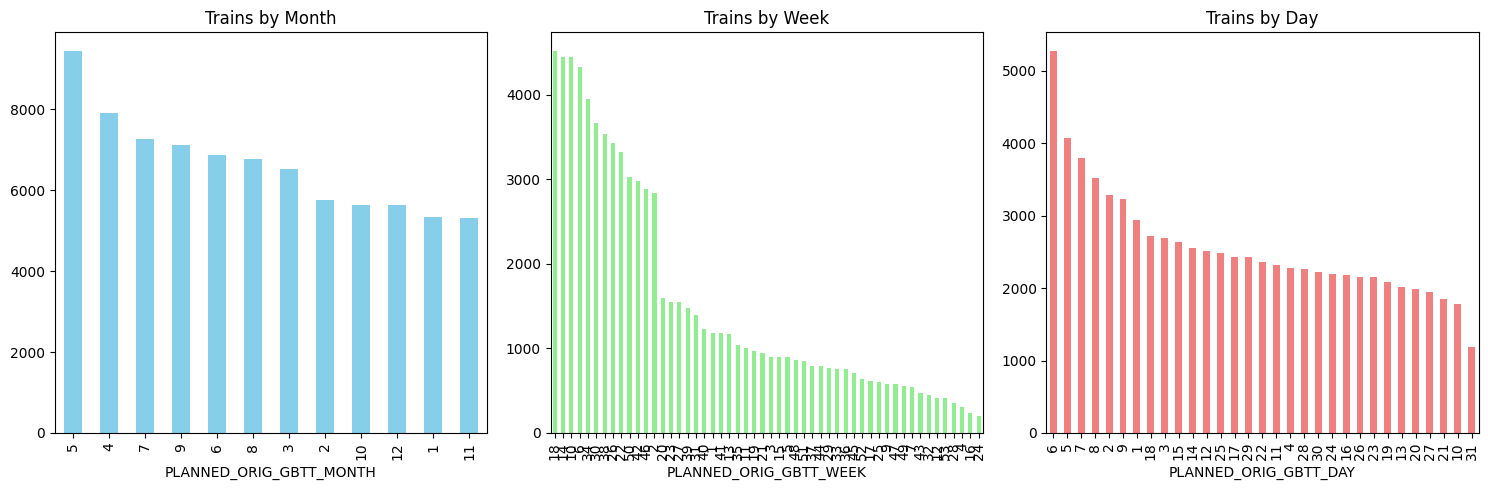

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

X_train['PLANNED_ORIG_GBTT_MONTH'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Trains by Month')

X_train['PLANNED_ORIG_GBTT_WEEK'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Trains by Week')

X_train['PLANNED_ORIG_GBTT_DAY'].value_counts().plot(kind='bar', ax=axes[2], color='lightcoral')
axes[2].set_title('Trains by Day')

plt.tight_layout()
plt.show()

In [13]:
X_train = u.add_cyclical_features(X_train, 'PLANNED_ORIG_GBTT_MONTH', 12)
X_train = u.add_cyclical_features(X_train, 'PLANNED_ORIG_GBTT_WEEK', 53)
X_train = u.add_cyclical_features(X_train, 'PLANNED_ORIG_GBTT_DAY', 31)
display(X_train)

,PLANNED_ORIG_LOC_CODE_AFF,PLANNED_ORIG_GBTT_DATETIME_AFF,PLANNED_DEST_LOC_CODE_AFFECTED,PLANNED_DEST_GBTT_DATETIME_AFF,TRAIN_SERVICE_CODE_AFFECTED,SERVICE_GROUP_CODE_AFFECTED,ENGLISH_DAY_TYPE,APP_TIMETABLE_FLAG_AFF,TRAIN_SCHEDULE_TYPE_AFFECTED,TRACTION_TYPE_AFFECTED,...,REACTIONARY_REASON_CODE,PLANNED_ORIG_GBTT_MONTH,PLANNED_ORIG_GBTT_WEEK,PLANNED_ORIG_GBTT_DAY,PLANNED_ORIG_GBTT_MONTH_sin,PLANNED_ORIG_GBTT_MONTH_cos,PLANNED_ORIG_GBTT_WEEK_sin,PLANNED_ORIG_GBTT_WEEK_cos,PLANNED_ORIG_GBTT_DAY_sin,PLANNED_ORIG_GBTT_DAY_cos
80896,52051,2019-07-25 08:17:00,87651,2019-07-25 09:14:00,22215003,EK03,WD,Y,(V)STP Overlay,EMU,...,None,7,30,25,-5.000000e-01,-8.660254e-01,-0.403123,-0.915146,-0.937752,0.347305
40398,72000,2021-05-08 17:31:00,72410,2021-05-08 18:22:00,22216000,EK02,WD,Y,LTP,EMU,...,None,5,18,8,5.000000e-01,-8.660254e-01,0.845596,-0.533823,0.998717,-0.050649
114227,87219,2023-05-06 08:04:00,52226,2023-05-06 09:08:00,22214000,EK01,SA,Y,LTP,EMU,...,,5,18,6,5.000000e-01,-8.660254e-01,0.845596,-0.533823,0.937752,0.347305
106724,52226,2018-06-25 18:17:00,87219,2018-06-25 19:19:00,22214000,EK01,WD,Y,LTP,EMU,...,YB,6,26,25,1.224647e-16,-1.000000e+00,0.059241,-0.998244,-0.937752,0.347305
133826,72419,2020-03-08 10:50:00,51531,2020-03-08 11:24:00,21921000,EK01,WD,Y,LTP,EMU,...,None,3,10,8,1.000000e+00,6.123234e-17,0.926690,0.375828,0.998717,-0.050649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16023,52226,2020-12-24 21:03:00,87219,2020-12-24 22:06:00,22204000,EK01,WD,Y,LTP,EMU,...,None,12,52,24,-2.449294e-16,1.000000e+00,-0.118273,0.992981,-0.988468,0.151428
126324,52051,2023-03-10 18:17:00,87651,2023-03-10 19:13:00,22215003,EK03,WD,Y,LTP,EMU,...,YI,3,10,10,1.000000e+00,6.123234e-17,0.926690,0.375828,0.897805,-0.440394
137337,72410,2023-01-08 08:13:00,72000,2023-01-08 09:04:00,22216000,EK02,SU,Y,LTP,EMU,...,,1,1,8,5.000000e-01,8.660254e-01,0.118273,0.992981,0.998717,-0.050649
54886,87651,2019-05-29 10:46:00,52051,2019-05-29 11:38:00,22218000,EK99,WD,Y,LTP,EMU,...,,5,22,29,5.000000e-01,-8.660254e-01,0.508531,-0.861044,-0.394356,0.918958


In [14]:
X_train.drop(columns=['PLANNED_ORIG_GBTT_DATETIME_AFF','PLANNED_DEST_GBTT_DATETIME_AFF',
                      'PLANNED_ORIG_GBTT_MONTH', 'PLANNED_ORIG_GBTT_WEEK','PLANNED_ORIG_GBTT_DAY'],inplace=True)
display(X_train.columns)

Index(['PLANNED_ORIG_LOC_CODE_AFF', 'PLANNED_DEST_LOC_CODE_AFFECTED',
       'TRAIN_SERVICE_CODE_AFFECTED', 'SERVICE_GROUP_CODE_AFFECTED',
       'ENGLISH_DAY_TYPE', 'APP_TIMETABLE_FLAG_AFF',
       'TRAIN_SCHEDULE_TYPE_AFFECTED', 'TRACTION_TYPE_AFFECTED',
       'UNIT_CLASS_AFFECTED', 'SECTION_CODE', 'NETWORK_RAIL_LOCATION_MANAGER',
       'RESPONSIBLE_MANAGER', 'INCIDENT_REASON', 'REACTIONARY_REASON_CODE',
       'PLANNED_ORIG_GBTT_MONTH_sin', 'PLANNED_ORIG_GBTT_MONTH_cos',
       'PLANNED_ORIG_GBTT_WEEK_sin', 'PLANNED_ORIG_GBTT_WEEK_cos',
       'PLANNED_ORIG_GBTT_DAY_sin', 'PLANNED_ORIG_GBTT_DAY_cos'],
      dtype='object')

## <a id='toc1_3_'></a>[Geographical Features](#toc0_)

The departure and arrival stations are expresses as STANOX codes (stations identifier codes). The number of unique STANOX codes is too high to consider one-hot encoding, so we are going to retrieve the latitude/longitude of each station. In order to do so, we are going to scrape the TIPLOC-STANOX association from the http://www.railwaycodes.org.uk/crs/crsa.shtm website, and then retrieve the latitude and longitude from the dataset available at https://www.data.gov.uk/dataset/ff93ffc1-6656-47d8-9155-85ea0b8f2251/national-public-transport-access-nodes-naptan.


In [15]:
stanox_cols = ['PLANNED_ORIG_LOC_CODE_AFF','PLANNED_DEST_LOC_CODE_AFFECTED']
u.print_summary_stats(df = X_train, cols_list=stanox_cols)

Missing Values:
PLANNED_ORIG_LOC_CODE_AFF         0.0
PLANNED_DEST_LOC_CODE_AFFECTED    0.0
dtype: float64

Unique Values:
PLANNED_ORIG_LOC_CODE_AFF         47
PLANNED_DEST_LOC_CODE_AFFECTED    40
dtype: int64

Value Counts:

PLANNED_ORIG_LOC_CODE_AFF
52226    12466
87219    10808
87651     6447
87132     6110
52051     5683
72419     5114
72410     4781
52074     4561
52741     4520
72000     2839
52731     2786
51531     2614
87625     2599
88392     2234
51815     2097
51946     2092
72275      770
51533      182
87603      126
87203      119
72277      118
72421      100
72253       68
72313       51
52088       42
72242       34
63641       32
50392       30
52040       29
50401       22
51541       18
87572       17
72017       12
51558       11
87626        4
72241        4
51951        3
72413        2
52733        2
72311        2
87574        2
87568        2
72273        2
52736        1
51529        1
72271        1
52053        1
Name: count, dtype: int64

PLANNED_DEST_LOC

In [82]:
lon_lat_df = u.read_data_from_bq(credentials = SERVICE_ACCOUNT,
                  gcp_project = GCP_PROJECT, bq_dataset = BQ_DATASET,
                  table = GEO_COOORDINATES_TABLE_ID)

In [84]:
lon_lat_df.head()

,Station_Name,Stanox,Latitude,Longitude
0,Edmonton Green Rail Station,51949,51.624929,-0.061087
1,Clapham Junction,87219,51.463350,-0.172530
2,Shenfield Rail Station,50328,51.630878,0.329879
3,Walthamstow Queens Road Rail Station,51553,51.581503,-0.023819
4,South Tottenham,51558,51.580430,-0.071820


In [86]:
lon_lat_df = lon_lat_df[['Stanox','Latitude','Longitude']]
X_train = pd.merge(X_train, lon_lat_df, left_on='PLANNED_ORIG_LOC_CODE_AFF',right_on='Stanox', how='left')
X_train.rename(columns={'Latitude':'ORIG_LAT','Longitude':'ORIG_LON'},inplace=True)
X_train = pd.merge(X_train, lon_lat_df, left_on='PLANNED_DEST_LOC_CODE_AFFECTED',right_on='Stanox', how='left')
X_train.rename(columns={'Latitude':'DEST_LAT','Longitude':'DEST_LON'},inplace=True)
X_train.drop(columns=['PLANNED_ORIG_LOC_CODE_AFF', 'PLANNED_DEST_LOC_CODE_AFFECTED','Stanox_x','Stanox_y'])

In [96]:
X_train.head()

,TRAIN_SERVICE_CODE_AFFECTED,SERVICE_GROUP_CODE_AFFECTED,ENGLISH_DAY_TYPE,APP_TIMETABLE_FLAG_AFF,TRAIN_SCHEDULE_TYPE_AFFECTED,TRACTION_TYPE_AFFECTED,UNIT_CLASS_AFFECTED,SECTION_CODE,NETWORK_RAIL_LOCATION_MANAGER,RESPONSIBLE_MANAGER,...,PLANNED_ORIG_GBTT_MONTH_sin,PLANNED_ORIG_GBTT_MONTH_cos,PLANNED_ORIG_GBTT_WEEK_sin,PLANNED_ORIG_GBTT_WEEK_cos,PLANNED_ORIG_GBTT_DAY_sin,PLANNED_ORIG_GBTT_DAY_cos,ORIG_LAT,ORIG_LON,DEST_LAT,DEST_LON
0,22215003,EK03,WD,Y,(V)STP Overlay,EMU,375.0,52084:87568,OQYA,REKE,...,-5.000000e-01,-8.660254e-01,-0.403123,-0.915146,-0.937752,0.347305,51.546500,-0.104080,51.378426,-0.10256
1,22216000,EK02,WD,Y,LTP,EMU,378.0,72017:72277,OQNU,VEK1,...,5.000000e-01,-8.660254e-01,0.845596,-0.533823,0.998717,-0.050649,51.663671,-0.396145,51.529910,-0.13592
2,22214000,EK01,SA,Y,LTP,EMU,378.0,52045:52226,OQHQ,IQHP,...,5.000000e-01,-8.660254e-01,0.845596,-0.533823,0.937752,0.347305,51.463350,-0.172530,51.542300,-0.00330
3,22214000,EK01,WD,Y,LTP,EMU,375.0,72275,OQHQ,TEKT,...,1.224647e-16,-1.000000e+00,0.059241,-0.998244,-0.937752,0.347305,51.542300,-0.003300,51.463350,-0.17253
4,21921000,EK01,WD,Y,LTP,EMU,710.0,51558:51541,OQHS,IQHN,...,1.000000e+00,6.123234e-17,0.926690,0.375828,0.998717,-0.050649,51.555480,-0.151360,51.540140,0.07965
